In [11]:
import cv2
import numpy as np
import random as rand
import matplotlib.pyplot as plt
from random import randrange


# Assignment 2


## Task 01:

Implement the SIFT algorithm from scratch in Python/MATLAB. Apply your implementation to a pair of
images and find correspondences between keypoints.


### Implementing through Library

In [16]:
# Loading the image
image = cv2.imread('ID.png')

# Converting the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Initializing the SIFT detector
sift = cv2.SIFT_create()

# Detecting keypoints in the grayscale image
keypoints = sift.detect(image, None)

# Marking the keypoints on the original image using circles
image_with_keypoints = cv2.drawKeypoints(image, keypoints, image, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


# Saving the result
cv2.imwrite('opencvSIFT.jpg', image_with_keypoints)

True

### Implementing through scratch

Extracting SIFT Features

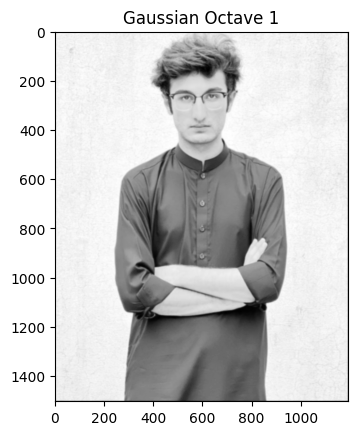

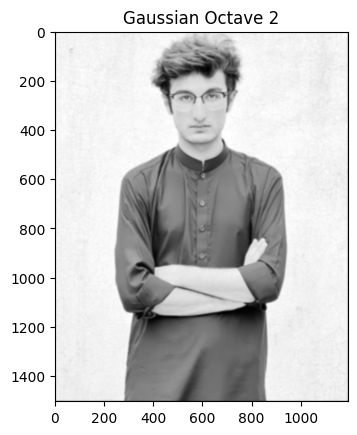

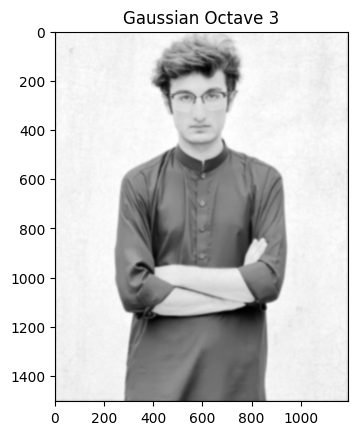

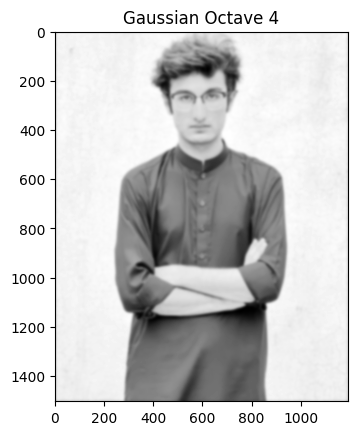

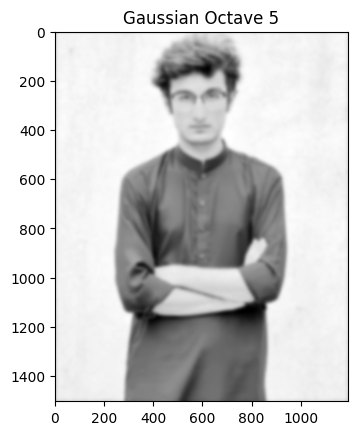

KeyboardInterrupt: 

In [21]:
def extractSIFTFeatures(gray, octaves, scales, sigma, sigmaN, k):
    """
    Extracts Scale-Invariant Feature Transform (SIFT) features from a grayscale image.

    Parameters:
    - gray_image (numpy.ndarray): The input grayscale image.
    - octaves (int): The number of octaves in the image pyramid.
    - scales (int): The number of scales per octave.
    - sigma (float): The initial scale of the Gaussian kernel.
    - sigmaN (float): The standard deviation for the DoG (Difference of Gaussians) kernel.
    - k (float): The factor between the scales in each octave.

    Returns:
    - list: List of SIFT features with coordinates, scale, and orientation.
    """
    r1, c1 = gray.shape

    gaussianOctaves = []
    gaussianOctaves.append(buildFirstGaussianOctave(gray, scales, sigma, sigmaN, k))

    for i in range(1, octaves):
        baseImage = gaussianOctaves[i - 1][2]
        row, col = baseImage.shape
        gaussianOctaves.append(buildGaussianOctave(baseImage[0:row:2, 0:col:2], scales, sigma, 0, k))

    dogOctaves = []
    for o in range(0, octaves):
        dogOctaves.append(buildDOGOctave(gaussianOctaves[o], scales))

    keypoints = []
    r = 10.0
    threshold = 0.03
    for o in range(0, octaves):
        keypoints.append(getKeyPoints(dogOctaves[o], threshold, r))

    O = []
    S = []
    for o in range(0, octaves):
        O.append(o - 1)
    for s in range(0, scales):
        S.append(np.power(k, s) * sigma)

    baseKeyPoints = []
    for o in range(0, octaves):
        kp = keypoints[o]
        numKP = len(kp)
        mag, ori = createGradientMagnitudeandOri(gaussianOctaves[o], S)
        Y, X = gaussianOctaves[o][0].shape
        p = np.power(2.0, O[o])
        for i in range(0, numKP):
            currKp = kp[i]
            x = np.multiply(currKp[0], p)
            y = np.multiply(currKp[1], p)
            s = currKp[2]
            if x < 0 or x > c1 - 1 or y < 0 or y > r1 - 1 or s < 0 or s > scales - 1:
                print("point coord out of range")
            sig = S[int(np.round(s))]
            newKps = generateOrientationHistogram(mag[int(np.round(s))], ori[int(np.round(s))], sig,
                                                  int(np.round(currKp[0])), int(np.round(currKp[1])))
            for pts in range(0, len(newKps)):
                newKp = []
                newKp.append(x)
                newKp.append(y)
                newKp.append(p)
                newKp.append(newKps[pts])
                baseKeyPoints.append(newKp)

    return baseKeyPoints


def buildFirstGaussianOctave(gray, scales, sigma, sigmaN, k):
    gaussianOctave = []
    dblGray = bilinearInterpolation(gray)
    

    for i in range(0, scales):
        desiredSigma = sigma * np.power(k, i)
        currSigma = np.sqrt(desiredSigma * desiredSigma - 2.0 * sigmaN * sigmaN)
        gaussianImage = cv2.GaussianBlur(dblGray, (0, 0), currSigma)
        gaussianOctave.append(gaussianImage)    

        # Plot the image after each Gaussian octave
        plt.imshow(gaussianImage, cmap='gray')
        plt.title(f'Gaussian Octave {i+1}')
        plt.show()

    return gaussianOctave


def buildGaussianOctave(baseImage, scales, sigma, sigmaN, k):
    """
    Builds a Gaussian octave for Scale-Invariant Feature Transform (SIFT).

    Parameters:
    - base_image (numpy.ndarray): The base image of the octave.
    - scales (int): The number of scales in the octave.
    - sigma (float): The initial scale of the Gaussian kernel.
    - sigma_n (float): The standard deviation for blurring.
    - k (float): The factor between the scales in the octave.

    Returns:
    - list: List of images representing the Gaussian octave.
    """

    gaussianOctave = []
    gaussianOctave.append(baseImage)

    for i in range(1, scales):
        desiredSigma = np.power(k, i) * sigma
        currSigma = np.sqrt(desiredSigma * desiredSigma - sigmaN * sigmaN)
        gaussianOctave.append(cv2.GaussianBlur(baseImage, (0, 0), currSigma))
    return gaussianOctave


def buildDOGOctave(gaussianOctave, scales):

    """
    Builds a Difference of Gaussians (DoG) octave for Scale-Invariant Feature Transform (SIFT).

    Parameters:
    - gaussian_octave (list): List of images representing the Gaussian octave.

    Returns:
    - list: List of images representing the DoG octave.
    """

    dogOctave = []

    for i in range(1, scales):
        dogOctave.append(np.subtract(gaussianOctave[i], gaussianOctave[i - 1]))

    return dogOctave


def createGradientMagnitudeandOri(gaussOctave, Scales):

    """
    Calculates gradient magnitude and orientation for an image in a Gaussian octave.

    Parameters:
    - gauss_octave (list): List of images representing the Gaussian octave.
    - scales (list): List of scales corresponding to the images in the octave.

    Returns:
    - tuple: A tuple containing lists of gradient magnitudes and orientations.
    """

    row, col = gaussOctave[0].shape
    magnitudes = []
    orientations = []
    eps = 1e-10
    for k in range(0, len(gaussOctave)):
        mag = np.zeros((row, col), gaussOctave[0].dtype)
        ori = np.zeros((row, col), gaussOctave[0].dtype)
        for j in range(1, row - 1):
            for i in range(1, col - 1):
                dx = gaussOctave[k][j, i + 1] - gaussOctave[k][j, i - 1]
                dy = gaussOctave[k][j + 1, i] - gaussOctave[k][j - 1, i]
                mag[j, i] = np.sqrt(dx * dx + dy * dy)
                ori[j, i] = np.arctan(dy / (dx + eps))
        sigma = Scales[k]
        mag = cv2.GaussianBlur(mag, (0, 0), 1.5 * sigma)
        magnitudes.append(mag)
        orientations.append(ori)
    return magnitudes, orientations


def generateOrientationHistogram(mag, ori, sig, x, y):
    """
    Generates orientation histogram for a given location in an image.

    Parameters:
    - magnitude (numpy.ndarray): Array representing the gradient magnitudes.
    - orientation (numpy.ndarray): Array representing the gradient orientations.
    - sigma (float): Standard deviation for the Gaussian blur.
    - x (int): x-coordinate of the location.
    - y (int): y-coordinate of the location.

    Returns:
    - list: List of dominant orientations.
    """

    wsize = int(2 * 1.5 * sig)
    nbins = 36
    hist = np.zeros((36,), dtype=mag.dtype)
    rows, cols = mag.shape

    for j in range(-wsize, wsize):
        for i in range(-wsize, wsize):
            r = y + j
            c = x + i
            if 0 <= r < rows and 0 <= c < cols:
                deg = ori[r, c] * 180.0 / np.pi
                hist[int(deg / 10)] += mag[r, c]

    peak_loc = np.argmax(hist)
    peak_val = hist[peak_loc]

    orientations = [peak_loc * 10 + 5]

    for k in range(nbins):
        if hist[k] >= 0.8 * peak_val and k != peak_loc:
            orientations.append(k * 10 + 5)

    # Plot the histogram
    plt.bar(np.arange(nbins) * 10 + 5, hist, width=10, align='edge')
    plt.title("Orientation Histogram")
    plt.xlabel("Degrees")
    plt.ylabel("Magnitude")
    plt.show()

    return orientations


def getKeyPoints(dogOctaves, threshold, r):
    """
    Detects keypoints in a Difference of Gaussians (DoG) octave.

    Parameters:
    - dog_octaves (list): List of images representing the DoG octave.
    - threshold (float): Threshold for keypoint detection.
    - r (float): Ratio for keypoint scoring.

    Returns:
    - list: List of keypoints as [x, y, z] coordinates.
    """

    keypoints = []
    max_iter = 5
    cnt1 = 0
    for DOG in range(1, len(dogOctaves) - 1):
        currDOG = dogOctaves[DOG]
        prevDOG = dogOctaves[DOG - 1]
        nextDOG = dogOctaves[DOG + 1]
        cnt = 0
        for j in range(1, currDOG.shape[0] - 1):
            for i in range(1, currDOG.shape[1] - 1):
                pix = currDOG[j, i]
                prevNeighborhood = prevDOG[j - 1:j + 2, i - 1:i + 2]
                currNeighborhood = currDOG[j - 1:j + 2, i - 1:i + 2]
                nextNeighborhood = nextDOG[j - 1:j + 2, i - 1:i + 2]

                fullNeighborhood = np.zeros((3, 3, 3), currNeighborhood.dtype)
                fullNeighborhood[:, :, 0] = prevNeighborhood[:, :]
                fullNeighborhood[:, :, 1] = currNeighborhood[:, :]
                fullNeighborhood[:, :, 2] = nextNeighborhood[:, :]

                minMax = localExtrema2(fullNeighborhood)
                if minMax == 0:
                    continue
                cnt += 1
                ptX = i
                ptY = j
                ptZ = DOG

                neighborHood = np.zeros((3, 3, 3), currNeighborhood.dtype)
                success = 0
                for iter in range(0, max_iter):
                    neighborHood[:, :, 0] = prevDOG[ptY - 1:ptY + 2, ptX - 1:ptX + 2]
                    neighborHood[:, :, 1] = currDOG[ptY - 1:ptY + 2, ptX - 1:ptX + 2]
                    neighborHood[:, :, 2] = nextDOG[ptY - 1:ptY + 2, ptX - 1:ptX + 2]
                    xHat, D_xHat, H, fail = getInterpolatedMaxima(fullNeighborhood)
                    if fail == 0:
                        break
                    if np.abs(xHat[0]) <= 0.5 and np.abs(xHat[1]) <= 0.5 and np.abs(xHat[2]) <= 0.5:
                        success = 1
                        break

                    if xHat[0] > 0.5:
                        ptX += 1
                    elif xHat[0] < -0.5:
                        ptX -= 1
                    if xHat[1] > 0.5:
                        ptY += 1
                    elif xHat[1] < -0.5:
                        ptY -= 1
                    if xHat[2] > 0.5:
                        ptZ += 1
                    elif xHat[2] < -0.5:
                        ptZ -= 1

                    if ptY < 1 or ptY > currDOG.shape[0] - 2:
                        break
                    if ptX < 1 or ptX > currDOG.shape[1] - 2:
                        break
                    if ptZ < 1 or ptZ > len(dogOctaves) - 2:
                        break

                if success == 1:
                    if np.abs(D_xHat) < threshold:
                        continue
                    score = np.square(H[0, 0] + H[1, 1]) / (H[0, 0] * H[1, 1] - np.square(H[0, 1]))
                    if score > (np.square(r + 1) / r):
                        continue
                    kp = []
                    kp.append(ptX + xHat[0])
                    kp.append(ptY + xHat[1])
                    kp.append(ptZ + xHat[2])
                    keypoints.append(kp)
                    cnt1 += 1
    return keypoints


def getInterpolatedMaxima(fullNeighborhood):
    """
    Calculates the interpolated maxima for a 3D neighborhood.

    Parameters:
    - full_neighborhood (numpy.ndarray): 3D array representing the neighborhood.

    Returns:
    - tuple: A tuple containing the interpolated maxima, the interpolated gradient, Hessian matrix, and success flag.
    """

    H, H1 = getHessianofDOG(fullNeighborhood)
    D = getDerivativeDOG(fullNeighborhood)
    minus_D = np.multiply(-1.0, D)
    xHat = np.zeros((3, 1), H.dtype)
    D_xhat = 0

    try:
        xHat = np.linalg.solve(H, minus_D)
        pix = fullNeighborhood[1, 1, 1]
        D_xhat = pix + 0.5 * (D[0] * xHat[0] + D[1] * xHat[1] + D[2] * xHat[2])
        return xHat, D_xhat, H1, 1
    except np.linalg.LinAlgError:
        return xHat, D_xhat, H1, 0


def getHessianofDOG(neighborhood):

    """
    Calculates the Hessian matrix and its 2x2 submatrix for a given 3D neighborhood.

    Parameters:
    - neighborhood (numpy.ndarray): 3D array representing the neighborhood.

    Returns:
    - tuple: A tuple containing the full Hessian matrix and its 2x2 submatrix.
    """

    i = 1
    j = 1
    sigma = 1
    D2_x2 = neighborhood[j, i + 1, sigma] - 2.0 * neighborhood[j, i, sigma] + neighborhood[j, i - 1, sigma]
    D2_y2 = neighborhood[j + 1, i, sigma] - 2.0 * neighborhood[j, i, sigma] + neighborhood[j - 1, i, sigma]
    D2_sigma2 = neighborhood[j, i, sigma + 1] - 2.0 * neighborhood[j, i, sigma] + neighborhood[j, i, sigma - 1]
    D2_x_y = neighborhood[j + 1, i + 1, sigma] - neighborhood[j - 1, i + 1, sigma] - neighborhood[j + 1, i - 1, sigma] + \
             neighborhood[j - 1, i - 1, sigma]
    D2_x_y /= 4.0
    D2_x_sigma = neighborhood[j, i + 1, sigma + 1] - neighborhood[j, i + 1, sigma - 1] - neighborhood[
        j, i - 1, sigma + 1] + neighborhood[j, i - 1, sigma - 1]
    D2_x_sigma /= 4.0
    D2_y_sigma = neighborhood[j + 1, i, sigma + 1] - neighborhood[j + 1, i, sigma - 1] - neighborhood[
        j - 1, i, sigma + 1] + neighborhood[j - 1, i, sigma - 1]
    D2_y_sigma /= 4.0

    Hessian = np.zeros((3, 3), neighborhood.dtype)
    Hessian[0, 0] = D2_x2
    Hessian[0, 1] = D2_x_y
    Hessian[0, 2] = D2_x_sigma

    Hessian[1, 0] = D2_x_y
    Hessian[1, 1] = D2_y2
    Hessian[1, 2] = D2_y_sigma

    Hessian[2, 0] = D2_x_sigma
    Hessian[2, 1] = D2_y_sigma
    Hessian[2, 2] = D2_sigma2

    Hessian_CurrentScale = np.zeros((2, 2), Hessian.dtype)
    Hessian_CurrentScale[0, 0] = D2_x2
    Hessian_CurrentScale[0, 1] = D2_x_y
    Hessian_CurrentScale[1, 0] = D2_x_y
    Hessian_CurrentScale[1, 1] = D2_y2

    return Hessian, Hessian_CurrentScale


def getDerivativeDOG(neighborhood):
    """
    Calculates the derivative of the Difference of Gaussians (DoG) for a given 3D neighborhood.

    Parameters:
    - neighborhood (numpy.ndarray): 3D array representing the neighborhood.

    Returns:
    - numpy.ndarray: Array containing the derivatives along x, y, and sigma dimensions.
    """

    i = 1
    j = 1
    sigma = 1
    Dx = (neighborhood[j, i + 1, sigma] - neighborhood[j, i - 1, sigma]) / 2.0
    Dy = (neighborhood[j + 1, i, sigma] - neighborhood[j - 1, i, sigma]) / 2.0
    Dsigma = (neighborhood[j, i, sigma + 1] - neighborhood[j, i, sigma - 1]) / 2.0
    D = np.zeros((3, 1), neighborhood.dtype)
    D[0] = Dx
    D[1] = Dy
    D[2] = Dsigma

    return D


def localExtrema1(n):
    isExtrema = 1
    pix = n[1, 1, 1]
    if pix >= 0:
        for i in range(3):
            for j in range(3):
                for k in range(3):
                    if i == 1 and j == 1 and k == 1:
                        continue
                    if pix < n[i, j, k]:
                        isExtrema = 0
    else:
        for i in range(3):
            for j in range(3):
                for k in range(3):
                    if i == 1 and j == 1 and k == 1:
                        continue
                    if pix > n[i, j, k]:
                        isExtrema = 0
    return isExtrema


def localExtrema(pix, neighborhood):

    """
    Checks if the center pixel of a 3x3x3 neighborhood is a local extrema.

    Parameters:
    - neighborhood (numpy.ndarray): 3D array representing the neighborhood.

    Returns:
    - bool: True if the center pixel is a local extrema, False otherwise.
    """

    lessThan = 0
    greaterThan = 0
    minMax = 1
    for k in range(3):
        for l in range(3):
            if greaterThan == 1 and lessThan == 1:
                minMax = 0
                break
            if pix >= neighborhood[k, l]:
                greaterThan = 1
            else:
                lessThan = 1

    return minMax


def localExtrema2(n):

    """
    Checks if the center pixel is a local extremum within a 3x3 neighborhood.

    A pixel is considered a local extremum if it is either greater than or less than all its neighbors.

    Parameters:
    - center_pixel (int): The value of the center pixel.
    - neighborhood (numpy.ndarray): A 2D array representing the 3x3 neighborhood.

    Returns:
    - bool: True if the center pixel is a local extremum, False otherwise.
    """

    pix = n[1, 1, 1]
    lessThan = 0
    greaterThan = 0
    isExtrema = 1
    numEq = 0

    for i in range(3):
        if isExtrema == 0:
            break
        for j in range(3):
            if isExtrema == 0:
                break
            for k in range(3):
                if lessThan == 1 and greaterThan == 1:
                    isExtrema = 0
                    break
                if i == 1 and j == 1 and k == 1:
                    continue
                if pix >= n[i, j, k]:
                    greaterThan = 1
                elif pix <= n[i, j, k]:
                    lessThan = 1
                else:
                    numEq += 1

    if numEq == 26:
        print("All same")
        isExtrema = 0

    return isExtrema


def bilinearInterpolation(gray):

    """
    Double the input image with bilinear interpolation in both dimensions.

    Parameters:
    - gray (numpy.ndarray): Input image assumed to be in the range [0, 1].

    Returns:
    - numpy.ndarray: Double-sized image obtained through bilinear interpolation.
    """

    r, c = gray.shape
    r1 = 2

def bilinearInterpolation(gray):
    # Double the input image with bilinear interpolation in both dimensions
    # Input image is assumed floating point b/w [0..1]
    r, c = gray.shape
    r1 = 2 * r
    c1 = 2 * c
    dest = np.zeros((r1, c1), gray.dtype)
    expanded = np.zeros((r + 2, c + 2), gray.dtype)
    expanded[1:r + 1, 1:c + 1] = gray[:, :]
    for j in range(1, r1 - 1):
        for i in range(1, c1 - 1):
            j1 = j / 2.0
            i1 = i / 2.0
            delY = j1 - int(j1)
            delX = i1 - int(i1)

            temp1 = (1.0 - delX) * expanded[int(j1), int(i1)] + delX * expanded[int(j1), int(i1) + 1]
            temp2 = (1.0 - delX) * expanded[int(j1) + 1, int(i1)] + delX * expanded[int(j1) + 1, int(i1) + 1]
            dest[j, i] = (1.0 - delY) * temp1 + delY * temp2

    return dest


    """
    Test SIFT feature extraction and display keypoints on the image.

    Parameters:
    - image_path (str): Path to the image file.

    Returns:
    - None
    """


img = cv2.imread('ID.png',cv2.IMREAD_COLOR)

gray1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = np.array(gray1.shape, np.float32)
gray = np.divide(gray1, 255.0)

gray = cv2.GaussianBlur(gray, (0, 0), 0.5)

k = np.sqrt(2.0)
keypoints = extractSIFTFeatures(gray, 4, 5, 1.6, 0.5, k)

for i in range(0, len(keypoints)):
    kp = keypoints[i]
    x = kp[0]
    y = kp[1]
    s = kp[2]
    cv2.circle(img,(int(np.round(x)),int(np.round(y))),int(5*s),(0,0,255))
    #cv2.ellipse(img, (int(np.round(x)), int(np.round(y))), (int(6 * s), int(4 * s)), kp[3], 0, 360,
                #(rand.randint(0, 255), rand.randint(0, 255), rand.randint(0, 255)))
print(len(keypoints))
cv2.imshow('SIFT Keypoints', img)
cv2.waitKey(0)

cv2.imwrite('customSIFT.jpg', img)

 

### Task : 02

Discover the methods of image stitching and stitch any two images.

#### Code:


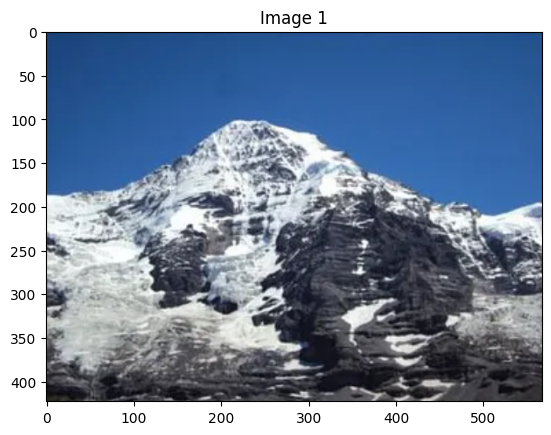

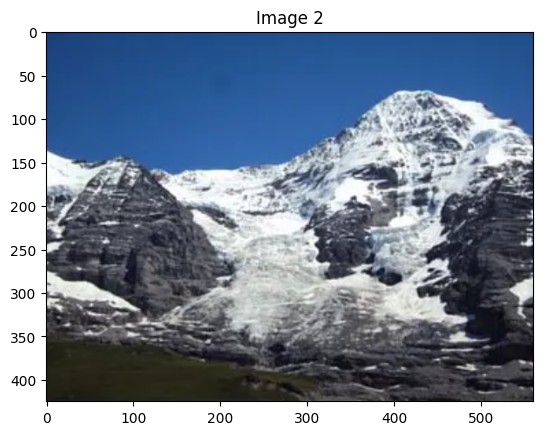

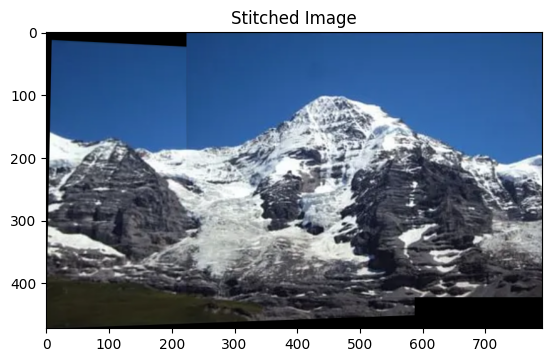

In [17]:
def FindMatches(BaseImage, SecImage):

    """
    Finds and visualizes keypoint matches between two input images using SIFT and Flann-based matcher.

    Parameters:
    - base_image (numpy.ndarray): The base image.
    - sec_image (numpy.ndarray): The secondary image.

    Returns:
    - numpy.ndarray: An image containing visualized keypoint matches.
    """

    # Using SIFT to find the keypoints and decriptors in the images
    Sift = cv2.SIFT_create()
    BaseImage_kp, BaseImage_des = Sift.detectAndCompute(cv2.cvtColor(BaseImage, cv2.COLOR_BGR2GRAY), None)
    SecImage_kp, SecImage_des = Sift.detectAndCompute(cv2.cvtColor(SecImage, cv2.COLOR_BGR2GRAY), None)

    # Using Brute Force matcher to find matches.
    BF_Matcher = cv2.BFMatcher()
    InitialMatches = BF_Matcher.knnMatch(BaseImage_des, SecImage_des, k=2)

    # Applying ratio test and filtering out the good matches.
    GoodMatches = []
    for m, n in InitialMatches:
        if m.distance < 0.75 * n.distance:
            GoodMatches.append([m])

    return GoodMatches, BaseImage_kp, SecImage_kp



def FindHomography(Matches, BaseImage_kp, SecImage_kp):

    """
    Finds the homography matrix between two sets of matched keypoints.

    Parameters:
    - matches (list): List of matches between keypoints.
    - base_image_kp (list): Keypoints in the base image.
    - sec_image_kp (list): Keypoints in the secondary image.

    Returns:
    - tuple: A tuple containing the homography matrix and a status flag.
    """

    # If less than 4 matches found, exit the code.
    if len(Matches) < 4:
        print("\nNot enough matches found between the images.\n")
        exit(0)

    # Storing coordinates of points corresponding to the matches found in both the images
    BaseImage_pts = []
    SecImage_pts = []
    for Match in Matches:
        BaseImage_pts.append(BaseImage_kp[Match[0].queryIdx].pt)
        SecImage_pts.append(SecImage_kp[Match[0].trainIdx].pt)

    # Changing the datatype to "float32" for finding homography
    BaseImage_pts = np.float32(BaseImage_pts)
    SecImage_pts = np.float32(SecImage_pts)

    # Finding the homography matrix(transformation matrix).
    (HomographyMatrix, Status) = cv2.findHomography(SecImage_pts, BaseImage_pts, cv2.RANSAC, 4.0)

    return HomographyMatrix, Status

    
def GetNewFrameSizeAndMatrix(HomographyMatrix, Sec_ImageShape, Base_ImageShape):

    """
    Calculates the new size and homography matrix after perspective transformation.

    Parameters:
    - homography_matrix (numpy.ndarray): The homography matrix.
    - sec_image_shape (tuple): The shape (height, width) of the secondary image.
    - base_image_shape (tuple): The shape (height, width) of the base image.

    Returns:
    - tuple: A tuple containing the new size (height, width), correction factors, and updated homography matrix.
    """


    # Reading the size of the image
    (Height, Width) = Sec_ImageShape
    
    # Taking the matrix of initial coordinates of the corners of the secondary image
    # Stored in the following format: [[x1, x2, x3, x4], [y1, y2, y3, y4], [1, 1, 1, 1]]
    # Where (xi, yi) is the coordinate of the i th corner of the image. 
    InitialMatrix = np.array([[0, Width - 1, Width - 1, 0],
                              [0, 0, Height - 1, Height - 1],
                              [1, 1, 1, 1]])
    
    # Finding the final coordinates of the corners of the image after transformation.
    # NOTE: Here, the coordinates of the corners of the frame may go out of the 
    # frame(negative values). We will correct this afterwards by updating the 
    # homography matrix accordingly.
    FinalMatrix = np.dot(HomographyMatrix, InitialMatrix)

    [x, y, c] = FinalMatrix
    x = np.divide(x, c)
    y = np.divide(y, c)

    # Finding the dimentions of the stitched image frame and the "Correction" factor
    min_x, max_x = int(round(min(x))), int(round(max(x)))
    min_y, max_y = int(round(min(y))), int(round(max(y)))

    New_Width = max_x
    New_Height = max_y
    Correction = [0, 0]
    if min_x < 0:
        New_Width -= min_x
        Correction[0] = abs(min_x)
    if min_y < 0:
        New_Height -= min_y
        Correction[1] = abs(min_y)
    
    # Again correcting New_Width and New_Height
    # Helpful when secondary image is overlaped on the left hand side of the Base image.
    if New_Width < Base_ImageShape[1] + Correction[0]:
        New_Width = Base_ImageShape[1] + Correction[0]
    if New_Height < Base_ImageShape[0] + Correction[1]:
        New_Height = Base_ImageShape[0] + Correction[1]

    # Finding the coordinates of the corners of the image if they all were within the frame.
    x = np.add(x, Correction[0])
    y = np.add(y, Correction[1])
    OldInitialPoints = np.float32([[0, 0],
                                   [Width - 1, 0],
                                   [Width - 1, Height - 1],
                                   [0, Height - 1]])
    NewFinalPonts = np.float32(np.array([x, y]).transpose())

    # Updating the homography matrix. Done so that now the secondary image completely 
    # lies inside the frame
    HomographyMatrix = cv2.getPerspectiveTransform(OldInitialPoints, NewFinalPonts)
    
    return [New_Height, New_Width], Correction, HomographyMatrix



def StitchImages(BaseImage, SecImage):

    """
    Stitches two images together using keypoint matching, homography, and perspective transformation.

    Parameters:
    - base_image (numpy.ndarray): The base image.
    - sec_image (numpy.ndarray): The secondary image.

    Returns:
    - numpy.ndarray: The stitched image.
    """

    # Finding matches between the 2 images and their keypoints
    Matches, BaseImage_kp, SecImage_kp = FindMatches(BaseImage, SecImage)
    
    # Finding homography matrix.
    HomographyMatrix, Status = FindHomography(Matches, BaseImage_kp, SecImage_kp)
    
    # Finding size of new frame of stitched images and updating the homography matrix 
    NewFrameSize, Correction, HomographyMatrix = GetNewFrameSizeAndMatrix(HomographyMatrix, SecImage.shape[:2], BaseImage.shape[:2])

    # Finally placing the images upon one another.
    StitchedImage = cv2.warpPerspective(SecImage, HomographyMatrix, (NewFrameSize[1], NewFrameSize[0]))
    StitchedImage[Correction[1]:Correction[1]+BaseImage.shape[0], Correction[0]:Correction[0]+BaseImage.shape[1]] = BaseImage

    return StitchedImage


if __name__ == "__main__":
    # Reading the 2 images.
    Image1 = cv2.imread("img1.png")
    Image2 = cv2.imread("img2.png")

    # Checking if images read
    if Image1 is None or Image2 is None:
        print("\nImages not read properly or do not exist.\n")
        exit(0)

    # Calling function for stitching images.
    StitchedImage = StitchImages(Image1, Image2)

     # Plotting each image separately
    plt.imshow(cv2.cvtColor(Image1, cv2.COLOR_BGR2RGB))
    plt.title('Image 1')
    plt.show()

    plt.imshow(cv2.cvtColor(Image2, cv2.COLOR_BGR2RGB))
    plt.title('Image 2')
    plt.show()

    plt.imshow(cv2.cvtColor(StitchedImage, cv2.COLOR_BGR2RGB))
    plt.title('Stitched Image')
    plt.show()
    
    # Keep the window open until closed by the user
    
    plt.show()
    